In [597]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro,Boltzmann

In [598]:
class MolecularDynamics1D_LJ:

    def __init__(self,epsilon,sigma,mass_amu,x,dt,steps,Temperature = 273):
        self.epsilon = epsilon #eV
        self.sigma = sigma #Å
        self.x = np.array(x, dtype=float) #Å
        self.Temperature = Temperature #K
        self.dt = dt  #ps
        self.steps = steps
        self.mass = (mass_amu/Avogadro)*1e-3 #kg
        self.v = None  

    def Potential_energy(self,x):
        # in eV
        x = np.array(x)
        r_ij = x[None, :] - x[:, None]
        r_mag = np.abs(r_ij)
        np.fill_diagonal(r_mag, np.inf)
        pe = 4*self.epsilon*( ((self.sigma/r_mag)**12) - ((self.sigma/r_mag)**6))
        return np.sum(pe,axis=0)

    def Force(self,r):
        # in (eV/Å)
        return 4*self.epsilon*((((12*np.power(self.sigma,12))/np.power(r,13)))-(((6*np.power(self.sigma,6))/np.power(r,7))))
    
    def Acceleration(self,x):
        #in Å/ps^2

        n = x.size
        r_ij = x[None, :] - x[:, None]
        r_mag = np.abs(r_ij)
        np.fill_diagonal(r_mag, np.inf)  # avoid self-interaction
        F_scalar = self.Force(r_mag)
        force = F_scalar * (r_ij / r_mag)
        net_force = np.sum(force, axis=0)
        acc_x = (net_force / self.mass) * 1.602e-23
        return acc_x


    def init_velocity(self,seed):
        n = self.x.size
        rng = np.random.default_rng(seed)
        mass_kg = self.mass
        
        # Standard deviation of velocity distribution (m/s)
        sigma = np.sqrt(Boltzmann * self.Temperature / mass_kg)
        
        # Draw from normal distribution
        velocities_mps = rng.normal(0.0, sigma, size=n)
        
        # Convert to Å/ps (1 m/s = 1e-2 Å/ps)
        velocities_ang_ps = velocities_mps * 1e-2
        self.v = velocities_ang_ps
        
        return velocities_ang_ps
    
    def Kinetic_Energy(self,v):
        #in eV
        return (self.mass*v**2*1e23)/(2*1.602)

    def run_verlet(self,seed =None):
        Pos_steps = np.zeros((self.steps, self.x.size))
        vel_steps = np.zeros((self.steps, self.x.size))
        
        self.init_velocity(seed)
        vel = self.v.copy()
        acc = self.Acceleration(self.x)
        pos = self.x.copy()
        dt = self.dt
        
        for i in range(self.steps):
            # Velocity-Verlet
            vel_half = vel + 0.5 * acc * dt
            newpos = pos + vel_half * dt
            newacc = self.Acceleration(newpos)
            newvel = vel_half + 0.5 * newacc * dt
            
            # Store
            Pos_steps[i, :] = newpos
            vel_steps[i, :] = newvel
            
            # Update for next step
            pos = newpos
            vel = newvel
            acc = newacc
        
        return Pos_steps, vel_steps
    



In [599]:
#intialize
#initial pos
pos = np.array([1,5,10])


#time- step
dt = 0.01  # pico - sec

#number of steps
steps = 1000

#temperature 
temp =273

#Inert gas = Argon

mass = (39.95) #Kg
epsilon = 0.0104#eV
sigma = 3.40 #Å

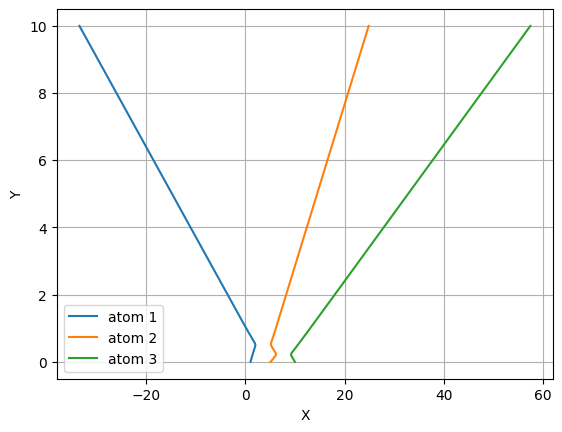

In [600]:
System = MolecularDynamics1D_LJ(epsilon,sigma,mass,pos,dt,steps)



pos_2,vel = System.run_verlet(63)

vel

System.Acceleration(System.x)
t = np.arange(0,steps*dt,dt)
for i in range (System.x.shape[0]):
    plt.plot(pos_2[:,i],t,label = 'atom {}'.format(i+1))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
# pos_2

## 2D Molecular Dynamics 

In [601]:
import numpy as np

class LJ_MolecularDynamics:
    def __init__(self, pos, steps, dt, mass, epsilon, sigma, Temperature):
        self.pos = pos
        self.N = pos.shape[0]
        self.dim = pos.shape[1] if pos.ndim > 1 else 1
        self.steps = steps
        self.dt = dt
        self.mass = mass
        self.epsilon = epsilon
        self.sigma = sigma
        self.temperature = Temperature

    def LJ_Force(self, r_mag):
        """Lennard-Jones scalar force magnitude as function of distance."""
        return 4 * self.epsilon * (
            (12 * (self.sigma**12) / r_mag**13)
            - (6 * (self.sigma**6) / r_mag**7)
        )

    def getAcceleration(self, pos):
        """Compute accelerations for all particles given positions."""
        acc = np.zeros(shape=(self.N,self.N,self.dim))
        for i in range(self.N - 1):
            for j in range(i+1,self.N):
                r_vec = pos[j] - pos[i]
                r_mag = np.linalg.norm(r_vec)
                F_mag = self.LJ_Force(r_mag)
                F_vec = F_mag*r_vec/r_mag
                acc[i,j,:] = F_vec*1.602e-23/mass
                acc[j,i,:] = -acc[i,j,:]
        acc = np.sum(acc,axis=0)
        return acc
    
    def initVelocity(self,seed):
        rng = np.random.default_rng(seed=seed)
        sigma = np.sqrt(self.dim*Boltzmann*self.temperature/self.mass)
        vel = rng.normal(size=(self.N,self.dim))
        for i in range(self.N):
            vel[i] = sigma*vel[i]/np.linalg.norm(vel[i])
        vel_aps = vel*1e-2
        self.v = vel_aps
    
    def verlet(self,seed = None):
        Pos_steps = np.zeros((self.steps, self.N,self.dim))
        vel_steps = np.zeros((self.steps, self.N,self.dim))
        
        self.initVelocity(seed)
        vel = self.v.copy()
        acc = self.getAcceleration(self.pos)
        pos = self.pos.copy()
        dt = self.dt
        
        for i in range(self.steps):
            vel_half = vel + 0.5 * acc * dt
            newpos = pos + vel_half * dt
            newacc = self.getAcceleration(newpos)
            newvel = vel_half + 0.5 * newacc * dt
            Pos_steps[i, :] = newpos
            vel_steps[i, :] = newvel
            pos = newpos
            vel = newvel
            acc = newacc
        return Pos_steps, vel_steps
    
    def Kinetic_Energy(self,v):
        #in eV
        ke = np.zeros(shape=(self.steps,self.N))
        for i in range(self.steps):
            for j in range(self.N):
                for k in range(self.dim):
                    ke[i,j] += (self.mass*v[i,j,k]**2*1e23)/(2*1.602)
        return ke
    def Potential_Energy(self,pos):
        # in eV
        pe = np.zeros(shape=(self.steps,self.N))
        for i in range(self.steps):
            for j in range(self.N):
                r_vec = pos[j] - pos[i]
                r_mag = np.linalg.norm(r_vec)
                pe[i,j]+= 4*self.epsilon*( ((self.sigma/r_mag)**12) - ((self.sigma/r_mag)**6))
        return np.sum(pe)
    

In [ ]:
pos = np.array([[1,2],[5,6],[10,11]])

dt = 0.001
n = 10000
T =273
mass = (39.59/Avogadro)*1e-3
epsilon = 0.0104#eV
sigma = 3.40 #Å
print(pos)
t = np.arange(0,n*dt,dt)

system = LJ_MolecularDynamics(pos,n,dt,mass,epsilon=epsilon,sigma=sigma,Temperature=T)
# system.getAcceleration(system.pos)

res_pos,res_vel = system.verlet()
# system.Kinetic_Energy(res_vel)
res_pos[:,0,:]
system.getAcceleration(system.pos)

[[  1   2   3   8]
 [  5   6   7   8]
 [ 10  11  23 435]]


array([[ 6.88232932e-02,  6.88232932e-02,  6.88232932e-02,
         3.58595250e-14],
       [-6.88232932e-02, -6.88232932e-02, -6.88232932e-02,
         3.60610057e-14],
       [-1.17808139e-15, -1.17808139e-15, -3.03083511e-15,
        -7.19205307e-14]])

In [603]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for i in range(system.N):
#     ax.plot(res_pos[:,i,0], res_pos[:,i,1], t, label=f'Particle {i+1}')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.legend()
# plt.title('3D Trajectories of Particles')
# plt.grid(True)

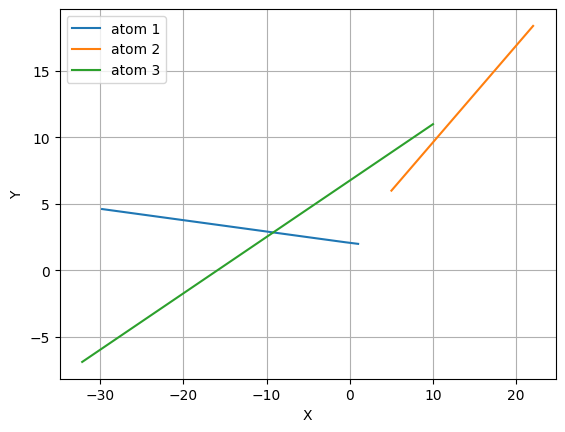

In [604]:
for i in range (system.N):
    plt.plot(res_pos[:,i,0],res_pos[:,i,1],label = 'atom {}'.format(i+1))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
# plt.show

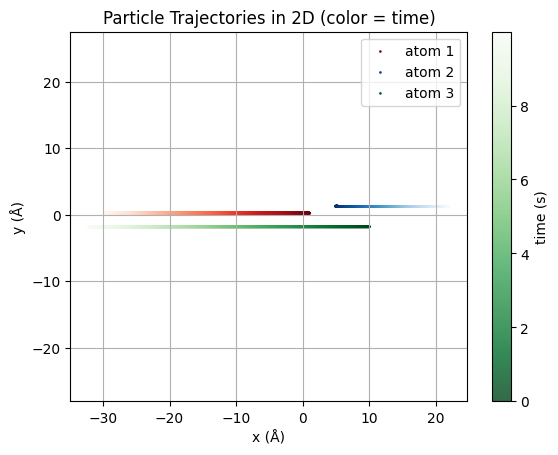

In [605]:
sc = [plt.cm.Reds_r,plt.cm.Blues_r,plt.cm.Greens_r]
for i in range(system.N):
    plt.scatter(x=res_pos[:,i,0],y=res_vel[:,i,1],c=t,cmap=sc[i],s=1,label = f'atom {i+1}',alpha=0.8)

plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.title('Particle Trajectories in 2D (color = time)')
plt.legend()
plt.grid()
plt.axis('equal')
plt.colorbar(label='time (s)')
plt.show()

In [606]:
np.random.rand?

Signature: np.random.rand(*args)
Docstring:
rand(d0, d1, ..., dn)

Random values in a given shape.

.. note::
    This is a convenience function for users porting code from Matlab,
    and wraps `random_sample`. That function takes a
    tuple to specify the size of the output, which is consistent with
    other NumPy functions like `numpy.zeros` and `numpy.ones`.

Create an array of the given shape and populate it with
random samples from a uniform distribution
over ``[0, 1)``.

Parameters
----------
d0, d1, ..., dn : int, optional
    The dimensions of the returned array, must be non-negative.
    If no argument is given a single Python float is returned.

Returns
-------
out : ndarray, shape ``(d0, d1, ..., dn)``
    Random values.

See Also
--------
random

Examples
--------
>>> np.random.rand(3,2)
array([[ 0.14022471,  0.96360618],  #random
       [ 0.37601032,  0.25528411],  #random
       [ 0.49313049,  0.94909878]]) #random
Type:      method